# 販売量の価格弾力性の推定

[Causal Inference in the Wild: Elasticity Pricing](https://github.com/larsroemheld/causalinf_ex_elasticity)の再現を目的にする。
コードは[ここ](https://github.com/larsroemheld/causalinf_ex_elasticity/blob/main/elasticity_dml.ipynb)。


In [3]:
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_parquet('https://github.com/larsroemheld/causalinf_ex_elasticity/raw/main/ecom_sample_clean.parquet')

In [4]:
df.set_index(['Date', 'StockCode', 'Country']).sample(10)

,,,Description,Quantity,revenue,UnitPrice
Date,StockCode,Country,,,,
2011-07-06,15044C,United Kingdom,PURPLE PAPER PARASOL,1,5.79,5.790000
2011-02-17,22429,United Kingdom,ENAMEL MEASURING JUG CREAM,3,16.79,5.596667
2011-11-28,22961,United Kingdom,JAM MAKING SET PRINTED,52,126.92,2.440769
2011-06-15,23103,United Kingdom,BELL HEART DECORATION,30,51.14,1.704667
2011-11-21,15044A,United Kingdom,PINK PAPER PARASOL,6,17.70,2.950000
2011-11-02,84876B,United Kingdom,GREEN HEART COMPACT MIRROR,3,3.75,1.250000
2011-10-27,84988,United Kingdom,SET OF 72 PINK HEART PAPER DOILIES,3,4.35,1.450000
2010-12-17,22739,United Kingdom,RIBBON REEL CHRISTMAS SOCK BAUBLE,9,28.53,3.170000
2011-12-07,21929,United Kingdom,JUMBO BAG PINK VINTAGE PAISLEY,14,29.12,2.080000


In [5]:
df_mdl = df[
    (df.groupby('StockCode').UnitPrice.transform('std') > 0)
]
del df



df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

"Naive" elasticity estimated to be -0.6064226294934305


/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LnQ   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.779
No. Observations:                  15   F-statistic:                     50.31
Covariance Type:            nonrobust   Prob (F-statistic):           8.13e-06
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3614      0.102     23.070      0.000       2.140       2.583
LnP           -0.6064      0.085     -7.093      0.000      -0.791      -0.422
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

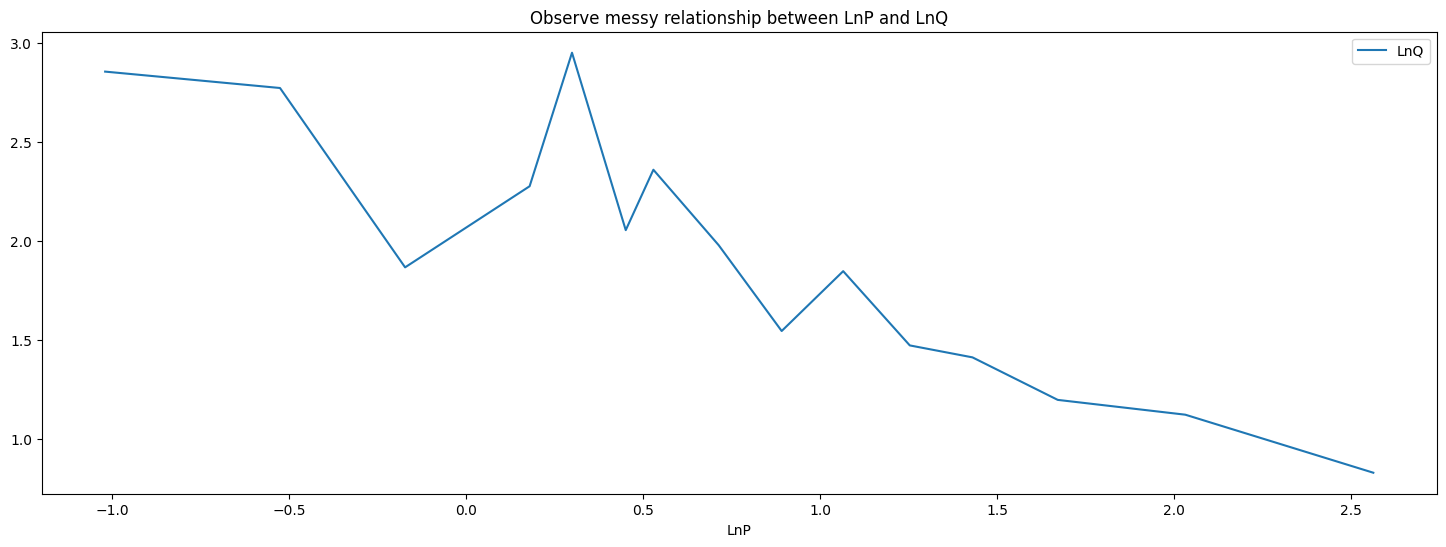

In [8]:


import statsmodels.api as sm # get full stats on regressions

def binned_ols(df, x, y, n_bins, plot=True, plot_title='', plot_ax=None, **plt_kwargs):
    # A visual form of de-noising: bin explanatory variable first, 
    # then take means-per-bin of variable to be explaioned, then
    # regress/plot 
    x_bin = x + '_bin'
    df[x_bin] = pd.qcut(df[x], n_bins)

    tmp = df.groupby(x_bin).agg({
        x: 'mean',
        y: 'mean'
    })

    if plot:
        tmp.plot(
            x=x, 
            y=y,
            figsize=(18, 6),
            title=plot_title,
            ax=plot_ax,
            **plt_kwargs
        )
    
    del df[x_bin]
    mdl = sm.OLS(tmp[y], sm.add_constant(tmp[x]))
    res = mdl.fit()
    return res



ols_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
    plot_title='Observe messy relationship between LnP and LnQ'
)

print(f'"Naive" elasticity estimated to be {ols_fit.params["LnP"]}')
ols_fit.summary(slim=True)

## Build standard econometrics-style causal model

In [12]:
import sklearn.preprocessing

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer



feature_generator_basic = ColumnTransformer(
    [
        ('StockCode', OneHotEncoder(), ['StockCode']),
        ('Date', OneHotEncoder(), ['Date']),
        ('Country', OneHotEncoder(), ['Country']),
        ('LnP', 'passthrough', ['LnP']),
    ], remainder='drop'
)

mdl_basic = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.PoissonRegressor(
        alpha=1e-6,  # l2 penalty strength; manually selected value for minimum interference on LnP-coef (elasticity)
        fit_intercept=False, # no need, since we have OneHot encodings without drop
        max_iter=100_000, 
    )),
], verbose=True)

mdl_basic_ols = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.Ridge(
        alpha=1e-20,  # l2 penalty strength, "very small"
        fit_intercept=False, 
        max_iter=100_000, 
    )),
], verbose=True)



In [13]:
mdl_basic.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['Quantity'] # Poisson regression has log-link, so LnQ is implicit in loss function
)



mdl_basic_ols.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['LnQ'] # log-normal
)



[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing reg, total=  16.9s
[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.4s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-20, fit_intercept=False, max_iter=100000))],
         verbose=True)

## DML Tree by hand

In [14]:
# Note that de-meaning happens on StockCode-level here!
df_mdl['dLnP'] = np.log(df_mdl.UnitPrice) - np.log(df_mdl.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl.Quantity) - np.log(df_mdl.groupby('StockCode').Quantity.transform('mean')) 



df_mdl = df_mdl.assign(
    month = lambda d: d.Date.dt.month,
    DoM =   lambda d: d.Date.dt.day,
    DoW =   lambda d: d.Date.dt.weekday,
    stock_age_days = lambda d: 
        (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    sku_avg_p = lambda d: 
        d.groupby('StockCode').UnitPrice.transform('median')
)

### Step 1: auxiliary models to orthogonalize T (price) and Y (quantity)

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
feature_generator_full = ColumnTransformer(
    [
        # do NOT include to reduce overfit (price is sku-level-demeaned anyway): 
        # ('StockCode', OneHotEncoder(), ['StockCode']), 
        ('Date', OneHotEncoder(), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p']),
    ], remainder='drop'
)

In [16]:
model_y = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_y', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0)) 
    # n_samples_leaf/n_estimators is set to reduce model (file) size and runtime
    # larger models yield prettier plots.
])
model_t = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_t', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0))
])

In [17]:
import joblib

try: # load existing models, if possible
    model_y = joblib.load('models/step1_model_y.joblib')
    model_t = joblib.load('models/step1_model_t.joblib')
except:
    print('No pre-existing models found, fitting aux models for y and t')
    model_y.fit(df_mdl, df_mdl.dLnQ)
    model_t.fit(df_mdl, df_mdl.dLnP)
    
    joblib.dump(model_y, 'models/step1_model_y.joblib', compress=True)
    joblib.dump(model_t, 'models/step1_model_t.joblib', compress=True)

No pre-existing models found, fitting aux models for y and t


In [ ]:
# Get first-step, predictions to residualize ("orthogonalize") with (in-sample for now)
q_hat = model_y.predict(df_mdl)
p_hat = model_t.predict(df_mdl)

In [ ]:
df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)

In [ ]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Naive causal regression after DML. Note that some variation in price & quantity is "explained away"',
    plot_ax=plt.gca()
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

In [ ]:
old_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Causal regression naively, with item controls, and after DML.',
    plot_ax=plt.gca()
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML (now supposedly valid estimate!) to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

In [ ]:
def get_feat_generator_names(gen):
    # workaround to sklearn native .get_feature_names() failing
    # because StandardScaler strangely doesn't implement it
    res = []
    for i, (k, t) in enumerate(gen.named_transformers_.items()):
        if k == 'remainder':
            continue
        try: 
            res += [f'{k}_{n}' for n in t.get_feature_names()]
        except:
            res += list(gen.transformers_[i][2])
    return res

In [ ]:
feat_imp = pd.DataFrame({
    'feat': get_feat_generator_names(model_y['feat_proc']),
    'importance_q': model_y['model_y'].feature_importances_,
    'importance_p': model_t['model_t'].feature_importances_,
}).set_index('feat')

feat_imp.sort_values(
    by='importance_p'
).iloc[-15:].plot.barh(
    figsize=(5, 8), 
    title='feature importances for DML estimators of treatment(p) and outcome(q)'
)

### Step 2: Inferential model for causal elasticity

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)
plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


elast_estimates = list()
for idx_aux, idx_inf in KFold(
    n_splits=2, shuffle=True).split(df_mdl):
    
    df_aux = df_mdl.iloc[idx_aux]
    df_inf = df_mdl.iloc[idx_inf].copy()
    
    # step 1: aux models and residualize in inferential set
    print('fitting model_y')
    model_y.fit(df_aux, df_aux.dLnQ)
    print('fitting model_t')
    model_t.fit(df_aux, df_aux.dLnP)
    
    df_inf = df_inf.assign(
        dLnP_res = df_inf['dLnP'] - model_t.predict(df_inf),
        dLnQ_res = df_inf['dLnQ'] - model_y.predict(df_inf),
    )
    
    binned_ols(
        df_inf,
        x='dLnP_res',
        y='dLnQ_res',
        n_bins=15,
        plot_ax=plt.gca(),
        label='fold'
    )

    
    # ignore observations where we residualized away all variation in price
    mask = (~(df_inf.dLnP_res.abs() < 0.01))
    df_inf_censored = df_inf[mask]
    
    # step 2.1: Chernozhukov DML inference
    elast = (
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP'])
        # the last part here deviates from standard OLS solution
    )
    
    print('DML elast: ', elast)
    elast_estimates.append(elast)

    print('OLS elasticity for comparison:',
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP_res'])
    )    

    elast_estimates.append(elast)

print("DML efficient estimate of elasticity:", np.mean(elast_estimates))